In [2]:
# import python libraries

import pandas as pd
import nbconvert
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xlrd
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
import re, string, unicodedata
import os
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import Word2Vec
import spacy
import math

In [3]:
# 1.0  Data Loading and Descriptive statistics.

#1.1  import data and create pandas dataframe
vehicle_input_df =  pd.read_excel("/SampleDataset.xlsx",na_values=' ')

In [4]:
#1.2 view the dataframe and display all columns and first 5 rows
vehicle_input_df.head()

,IDField,vMake,Manufactured,Age,VehicleType,EngineSize,DamageCat1,DamageCat2,DamageCat3,ActualOutput
0,98721,TOYOTA,2008,10,Hatchback,998.0,1,1,1,2
1,98016,SUZUKI,2005,13,Hatchback,1490.0,0,1,4,2
2,98011,RENAULT,2008,10,MPV,1598.0,1,0,1,2
3,97974,VAUXHALL,2006,12,MPV,1910.0,1,0,3,2
4,97960,NISSAN,2004,14,Hatchback,1240.0,2,1,0,2


In [5]:
#1.2 Data size: show the dataframe size of rows and columns, check if complete data as in input data dictionary with complete data read
vehicle_input_df.shape

(400, 10)

In [6]:
#1.3 Data types and count: show the data types and value count of each variable in the columns, check the columns with incomplete data for NaN or Null values

vehicle_input_df.info()  # display information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
IDField         400 non-null int64
vMake           400 non-null object
Manufactured    400 non-null int64
Age             400 non-null int64
VehicleType     398 non-null object
EngineSize      399 non-null float64
DamageCat1      400 non-null int64
DamageCat2      400 non-null int64
DamageCat3      400 non-null int64
ActualOutput    400 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 31.3+ KB


In [7]:
#1.4 Function to calculate percentage of NaN missing values in each variable of the dataset. columns where 70 to 100% of values are Null are dropped at this stage

def nan_percentage():
    ''' calcute the percentage of NaN values for each column in the dataframe and return only columns containing NaN and the percentage'''
    
    nandf = df.loc[:, df.isnull().any()]  # get columns containing nan values
    nan_percent = nandf.isnull().sum(axis = 0)/len(df)*100  # percentage of nan values
    
    return nan_percent
# call the function
df = vehicle_input_df
nan_percentage()

VehicleType    0.50
EngineSize     0.25
dtype: float64

In [8]:
#1.2 Variable unique values: Display the number of unique variables of each column

vehicle_input_df.nunique() # display number of unique values in each column

IDField         400
vMake            34
Manufactured     20
Age              20
VehicleType      12
EngineSize       96
DamageCat1        8
DamageCat2        8
DamageCat3        9
ActualOutput      2
dtype: int64

In [9]:
#1.5 Data statistics: show the data types and value count of each variable in the columns, check the columns with incomplete data for NaN or Null values

# QC display of the statics of numerical columns
vehicle_input_df.describe()

,IDField,Manufactured,Age,EngineSize,DamageCat1,DamageCat2,DamageCat3,ActualOutput
count,400.000000,400.000000,400.000000,399.000000,400.000000,400.000000,400.000000,400.000000
mean,89200.860000,2010.640000,7.360000,1616.478697,1.187500,0.950000,0.820000,1.500000
std,3794.429099,4.513461,4.513461,489.571224,1.275308,1.359087,1.607501,0.500626
min,83486.000000,1997.000000,0.000000,875.000000,0.000000,0.000000,0.000000,1.000000
25%,85860.250000,2007.000000,4.000000,1242.000000,0.000000,0.000000,0.000000,1.000000
50%,88903.000000,2011.000000,7.000000,1560.000000,1.000000,0.000000,0.000000,1.500000
75%,91905.250000,2014.000000,11.000000,1968.000000,2.000000,2.000000,1.000000,2.000000
max,98721.000000,2018.000000,21.000000,3999.000000,7.000000,7.000000,8.000000,2.000000


In [10]:
# Dataframe Statistics

# manufactured is from 1997 to 2018 which is a period of four years

# Observation on the following columns indicates the data distribution is skewed and as seen in the minimum and Maximum data values.

# 'EngineSize' has high mean 1616.478697 and low standard deviation 489.571224 

# 'Manufactured' has high mean 2010.640000 and low standard deviation 4.513461

good = 'good'

In [11]:
# 2.0 Data cleaning: In this process the variable coulumn is cleaned to contain the same data type.
# Before removing numbers and special caharacters of a variable the unique values are displayed and necessary changes are made.  

vehicle_clean_df = vehicle_input_df.copy()   #list the unique values of vMake
vehicle_clean_df.vMake.unique()

array(['TOYOTA', 'SUZUKI', 'RENAULT', 'VAUXHALL', 'NISSAN', 'VOLKSWAGEN',
       'FIAT', 'SKODA', 'KIA', 'CHEVROLET', 'HONDA', 'SMART', 'PEUGEOT',
       'FORD', 'LEXUS', 'CITROEN', 'ALFA ROMEO', 'MAZDA', 'BMW', 'AUDI',
       'DAEWOO', 'LOTUS', 'HYUNDAI', 'SEAT', 'MERCEDES', 'LAND ROVER',
       'SAAB', 'VOLVO', 'MINI', 'MERCEDES-BENZ', 'DS', 'JAGUAR',
       'PORSCHE', 'ISUZU'], dtype=object)

In [12]:
# 2.1 create a function to clean string data.

def clean_text(df = vehicle_clean_df, col= 'vMake'):
    '''This function returns a pandas list object of the given dataframe and column.
    The values of the column will be changed to lower case, remove spaces, punctuations and numbers,
    replace lines with non ascii characters that might exist'''
    
    df[col]= df[col].str.strip().str.lower().str.replace(' ', '').str.replace('[^\w\s]','').apply(lambda x: x.translate(string.punctuation)).apply(lambda x: x.translate(string.digits)).str.replace('[#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]','').str.replace(r'[^\x00-\x7f]', '')
    
    return df[col]
    
#call function

print(clean_text().unique())

['toyota' 'suzuki' 'renault' 'vauxhall' 'nissan' 'volkswagen' 'fiat'
 'skoda' 'kia' 'chevrolet' 'honda' 'smart' 'peugeot' 'ford' 'lexus'
 'citroen' 'alfaromeo' 'mazda' 'bmw' 'audi' 'daewoo' 'lotus' 'hyundai'
 'seat' 'mercedes' 'landrover' 'saab' 'volvo' 'mini' 'mercedesbenz' 'ds'
 'jaguar' 'porsche' 'isuzu']


In [13]:
# clean vMake column 
vehicle_clean_df['vmake'] = clean_text(df = vehicle_clean_df, col= 'vMake') # clean using the function clean_text

vehicle_clean_df['vmake'].head(2)

0    toyota
1    suzuki
Name: vmake, dtype: object

In [14]:
# check unique values of column VehicleType
vehicle_input_df['VehicleType'].unique()

array(['Hatchback', 'MPV', 'Estate', 'Coupe', 'Saloon', '4 DOOR SALOON',
       '5 DOOR HATCHBACK', '3 DOOR HATCHBACK', 'Convertible', 'Panel Van',
       nan, 'Minibus', 'Pick-up'], dtype=object)

In [15]:
# Comment change '5 DOOR HATCHBACK' to fivedoorhatcback and '3 DOOR HATCHBACK' to threedoorhatchback, nan to missing
# '4 DOOR SALOON' to fourdoorsaloon, panel Van to panelvan
# convert number to word, convert uppercase to lower case letters
# remove spaces and unwanted characters
# Data will remain unique and nothing missing

vehicle_clean_df['vehicletype'] = vehicle_clean_df['VehicleType'].copy()

vehicle_clean_df.vehicletype = vehicle_clean_df.vehicletype.str.replace('5 DOOR HATCHBACK', 'fivedoorhatcback')  # replace to character.

vehicle_clean_df.vehicletype = vehicle_clean_df.vehicletype.str.replace('3 DOOR HATCHBACK', 'threedoorhatchback')  # replace to character.

vehicle_clean_df.vehicletype = vehicle_clean_df.vehicletype.str.replace('4 DOOR SALOON', 'fourdoorsaloon')          # replace to character.

vehicle_clean_df.vehicletype = vehicle_clean_df.vehicletype.str.replace('panel Van', 'panelvan')  # remove space.

vehicle_clean_df.vehicletype = vehicle_clean_df.vehicletype.fillna('missing')  # fill missing values

vehicle_clean_df['vehicletype'] = clean_text(df = vehicle_clean_df, col= 'vehicletype') # clean using function clean_text

vehicle_clean_df['vehicletype'].unique()

array(['hatchback', 'mpv', 'estate', 'coupe', 'saloon', 'fourdoorsaloon',
       'fivedoorhatcback', 'threedoorhatchback', 'convertible',
       'panelvan', 'missing', 'minibus', 'pickup'], dtype=object)

In [16]:
vehicle_clean_df['vehicletype'].nunique()  # select unique values

13

In [17]:
vehicle_clean_df.head(3)  # display dataframe

,IDField,vMake,Manufactured,Age,VehicleType,EngineSize,DamageCat1,DamageCat2,DamageCat3,ActualOutput,vmake,vehicletype
0,98721,toyota,2008,10,Hatchback,998.0,1,1,1,2,toyota,hatchback
1,98016,suzuki,2005,13,Hatchback,1490.0,0,1,4,2,suzuki,hatchback
2,98011,renault,2008,10,MPV,1598.0,1,0,1,2,renault,mpv


In [18]:
# check unique values in Manufactured

vehicle_int_clean_df.Manufactured.unique()  # check unique values


NameError: name 'vehicle_int_clean_df' is not defined

In [19]:
# comment: There are nothing to remove in the column Manufactured 

In [20]:
# check unique values in EngineSize

vehicle_clean_df.EngineSize.unique()  # check unique values

array([ 998., 1490., 1598., 1910., 1240., 1390., 1896., 1242., 1149.,
       1086., 1248.,  996., 1991., 1229., 1339.,  999., 1360., 1388.,
       1988., 1796., 1560., 1956., 1349., 1596., 1999., 2993., 1968.,
       2184.,  995., 1997., 1461., 3456., 1595., 1197., 1364., 1341.,
       1995., 1198., 2685., 2926., 2204., 1398., 2198., 2967., 1199.,
       1590., 1497., 1781., 1124., 1299., 1753., 1397., 3311., 1399.,
       3189., 2435., 1586., 1396., 1587., 1368.,  875., 1686., 2393.,
       2792., 1422., 1950., 1591., 1798., 2497., 2179., 2979., 2400.,
       1984., 1969., 2401., 2998., 2987., 2231., 1328., 1618., 1499.,
       1685., 1329., 1395., 1200., 2143., 1582., 2995.,   nan, 1998.,
       2488., 3999.,  899., 2499., 1597., 1797., 2199.])

In [21]:
# There is nothing to clean in the column EngineSize except to replace nan value with median due to skewed distribution of the 
# data values

vehicle_clean_df.EngineSize = vehicle_clean_df.EngineSize.fillna(vehicle_clean_df.EngineSize.median())

vehicle_clean_df.EngineSize.unique()

array([ 998., 1490., 1598., 1910., 1240., 1390., 1896., 1242., 1149.,
       1086., 1248.,  996., 1991., 1229., 1339.,  999., 1360., 1388.,
       1988., 1796., 1560., 1956., 1349., 1596., 1999., 2993., 1968.,
       2184.,  995., 1997., 1461., 3456., 1595., 1197., 1364., 1341.,
       1995., 1198., 2685., 2926., 2204., 1398., 2198., 2967., 1199.,
       1590., 1497., 1781., 1124., 1299., 1753., 1397., 3311., 1399.,
       3189., 2435., 1586., 1396., 1587., 1368.,  875., 1686., 2393.,
       2792., 1422., 1950., 1591., 1798., 2497., 2179., 2979., 2400.,
       1984., 1969., 2401., 2998., 2987., 2231., 1328., 1618., 1499.,
       1685., 1329., 1395., 1200., 2143., 1582., 2995., 1998., 2488.,
       3999.,  899., 2499., 1597., 1797., 2199.])

In [22]:
vehicle_clean_df.DamageCat1.unique() # check unique valuea

array([1, 0, 2, 3, 5, 4, 7, 6], dtype=int64)

In [23]:
vehicle_clean_df.DamageCat2.unique()  # check unique valuea

array([1, 0, 5, 3, 2, 4, 7, 6], dtype=int64)

In [24]:
vehicle_clean_df.DamageCat3.unique()   # check unique valuea

array([1, 4, 3, 0, 5, 2, 6, 8, 7], dtype=int64)

In [25]:
vehicle_clean_df.ActualOutput.unique()   # check unique valuea

array([2, 1], dtype=int64)

In [26]:
# Drop the raw variables after  data cleaning

vehicle_clean_df1 = vehicle_clean_df.copy()

vehicle_clean_df1 = vehicle_clean_df1.drop(['vMake','VehicleType'], axis =1)  #drop columns 

vehicle_clean_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
IDField         400 non-null int64
Manufactured    400 non-null int64
Age             400 non-null int64
EngineSize      400 non-null float64
DamageCat1      400 non-null int64
DamageCat2      400 non-null int64
DamageCat3      400 non-null int64
ActualOutput    400 non-null int64
vmake           400 non-null object
vehicletype     400 non-null object
dtypes: float64(1), int64(7), object(2)
memory usage: 31.3+ KB


In [27]:
vehicle_clean_df1.shape

(400, 10)

In [28]:
# Save the cleaned dataframe to disk1 as a csv file

vehicle_clean_df1.to_csv("vehicle_clean_df1.csv")   # save out the data to disc


In [29]:
# Read data from disk

vehicle_clean_df1= pd.read_csv("/"vehicle_clean_df1.csv")

In [30]:
# 3.0 Exploratory Data Analysis.
'''
The plots are produced using Matplotlib and Seaborn libraries

The task in this project is classification, therefore this analysis explore the data that will adequately give a differentiation or separation
of the samples in the binary classifier.

The visualisation will show relationship between input features or variables.

Visualise data distribution of each variable for skew correction

This will also help to discover trend and patterns in the data and to understand data characteristics.

The Analysis is also aimed at discovering relationships in data engineering choice.

Plot include univariate plots using Histogram, Barplot, Bivariate plots such as Boxplots, Multivariate scatter plots and cluster plots.
'''
plot ='plot'

<Figure size 640x480 with 0 Axes>

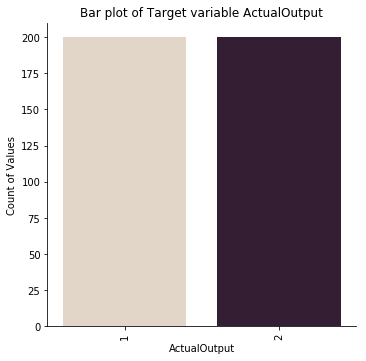

In [31]:
#3.1 BarPlot of target variable 'ActualOutput'
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.catplot(x="ActualOutput", kind="count",palette="ch:.25", data=vehicle_clean_df1)
plt.title('Bar plot of Target variable ActualOutput')
plt.xlabel('ActualOutput')
plt.ylabel('Count of Values')
plt.xticks(rotation='vertical')
#plt.legend(loc='best')
plt.show()

In [32]:
# Comment.
#The target data is balanced with equal number of values for the two classes 1 and 2
# There are 200 values for each class giving a total of 400 which is the data size

C:\Users\yasser\Anaconda2\envs\pyt36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1120x480 with 0 Axes>

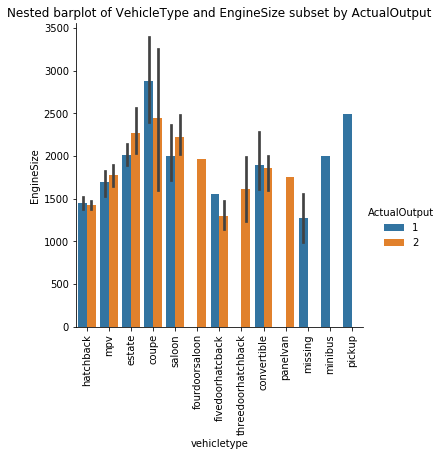

In [33]:
# Factor plot 
plt.figure(num=None, dpi=80,figsize =(14,6), facecolor='w', edgecolor='k')
sns.catplot('vehicletype', 'EngineSize', hue='ActualOutput', data=vehicle_clean_df1, kind='bar')
plt.title('Nested barplot of VehicleType and EngineSize subset by ActualOutput')
plt.xlabel('vehicletype')
plt.ylabel('EngineSize')
plt.xticks(rotation='vertical')
#plt.legend(loc='best')
plt.show()

In [34]:
# In the classification task, 
# fourdoorsaloon, threedoorhatchback,panelvan are ActualOutput 2 while missing, minibus and pickup are only Actualoutput 2 
# hence not good for the classification task. 
# Also hatchback contains equal number of both classes hence will not show any 
# difference between the two classes.

C:\Users\yasser\Anaconda2\envs\pyt36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


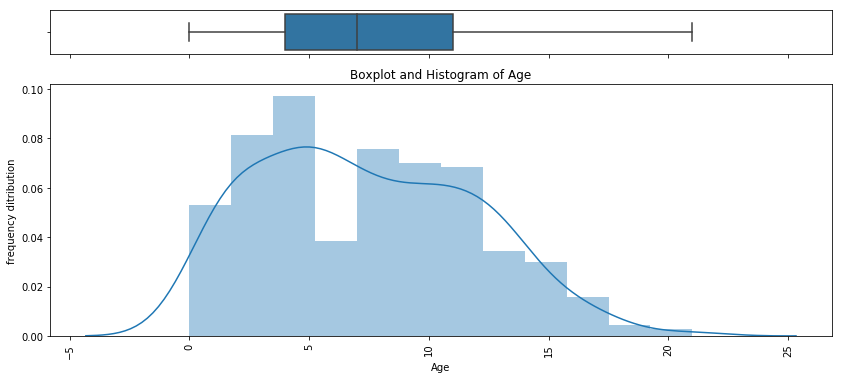

In [35]:
# Histogram of 'Age'

# Multiple plots boxplot and histograms in the same window
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, figsize =(14,6),sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(vehicle_clean_df1["Age"], ax=ax_box)
sns.distplot(vehicle_clean_df1["Age"], ax=ax_hist) 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.title('Boxplot and Histogram of Age')
plt.xlabel('Age')
plt.ylabel('frequency ditribution')
plt.xticks(rotation='vertical')
#plt.legend(loc='best')
plt.show()

In [36]:
# Vehicle age distribution is without outliers.

C:\Users\yasser\Anaconda2\envs\pyt36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


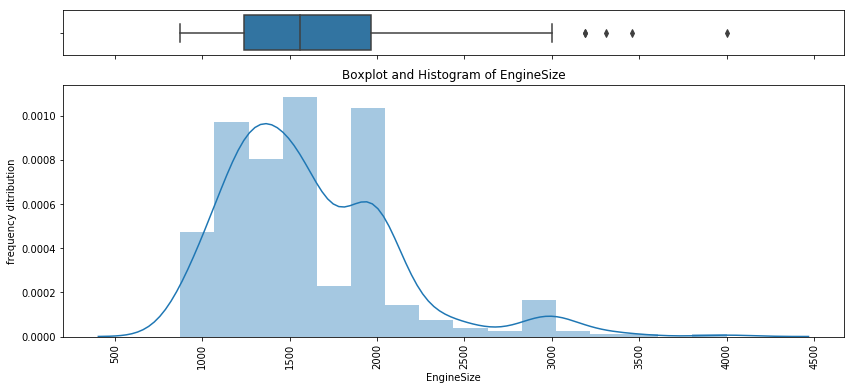

In [37]:
# Histogram of 'EngineSize'

# Multiple plots boxplot and histograms in the same window
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, figsize =(14,6),sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(vehicle_clean_df1["EngineSize"], ax=ax_box)
sns.distplot(vehicle_clean_df1["EngineSize"], ax=ax_hist) 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.title('Boxplot and Histogram of EngineSize')
plt.xlabel('EngineSize')
plt.ylabel('frequency ditribution')
plt.xticks(rotation='vertical')
#plt.legend(loc='best')
plt.show()


In [38]:
# EngineSize distribution is skwed and shows outliers hence has to be transformed
# plot histogram of log transformation of EngineSize

# Add 1 to replace zero before log transform
vehicle_clean_df1.loc[:,"EngineSizeLog"] = (vehicle_clean_df.loc[:,"EngineSize"]).apply(np.log)

C:\Users\yasser\Anaconda2\envs\pyt36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


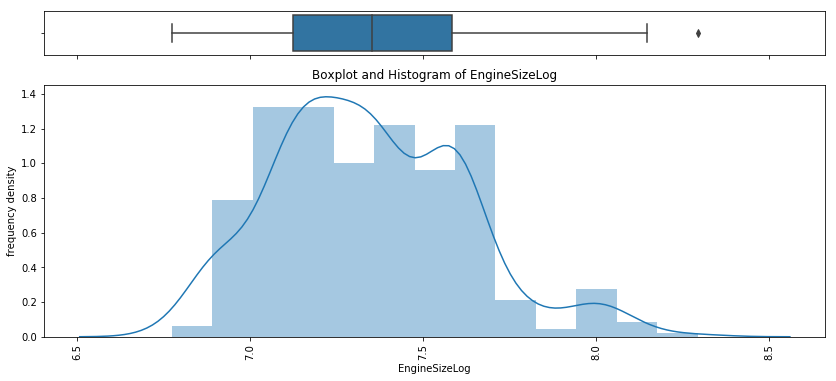

In [39]:
# Histogram of 'EngineSizeLog'
# Multiple histograms in the same window
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, figsize =(14,6),sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(vehicle_clean_df1["EngineSizeLog"], ax=ax_box)
sns.distplot(vehicle_clean_df1["EngineSizeLog"], ax=ax_hist) 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.title('Boxplot and Histogram of EngineSizeLog')
plt.xlabel('EngineSizeLog')
plt.ylabel('frequency density')
plt.xticks(rotation='vertical')
plt.show()

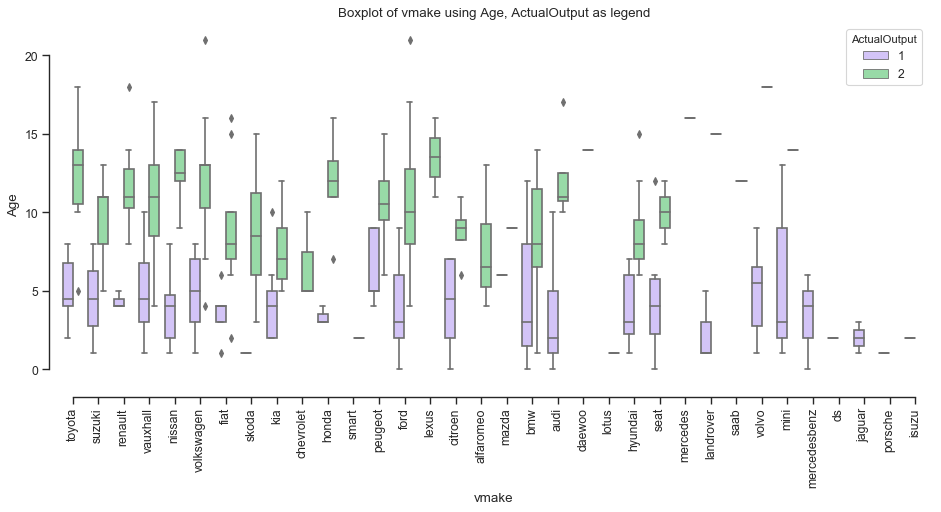

In [40]:
# grouped boxplot

sns.set(style="ticks", palette="pastel")

# Draw a nested boxplot to show bills by day and time
plt.figure(num=None, dpi=80,figsize =(14,6), facecolor='w', edgecolor='k')
#f, axes = plt.subplots(1, 1, figsize=(14, 14), sharex=True)
sns.boxplot(x="vmake", y="Age",
            hue="ActualOutput", palette=["m", "g"],
            data=vehicle_clean_df1)
sns.despine(offset=10, trim=True)
plt.title('Boxplot of vmake using Age, ActualOutput as legend' )
plt.xlabel('vmake')
plt.ylabel('Age')
plt.xticks(rotation='vertical')
#plt.legend(loc='best')
plt.show()

C:\Users\yasser\Anaconda2\envs\pyt36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


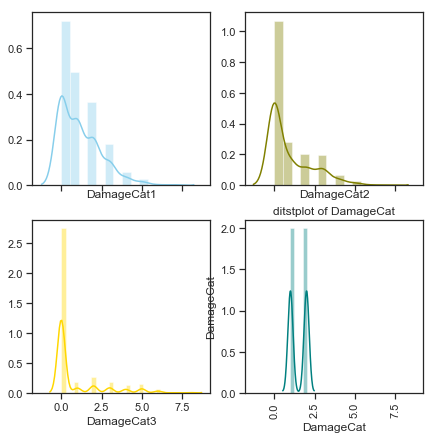

In [41]:
# plot multiple histograms on the same window
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.distplot(vehicle_clean_df1["DamageCat1"], color="skyblue", ax=axes[0, 0])
sns.distplot(vehicle_clean_df1["DamageCat2"], color="olive", ax=axes[0, 1])
sns.distplot(vehicle_clean_df1["DamageCat3"],color="gold", ax=axes[1, 0])
sns.distplot(vehicle_clean_df1["ActualOutput"], color="teal", ax=axes[1, 1])
plt.title('ditstplot of DamageCat' )
plt.xlabel('DamageCat')
plt.ylabel('DamageCat')
plt.xticks(rotation='vertical')
#plt.legend(loc='best')
plt.show()


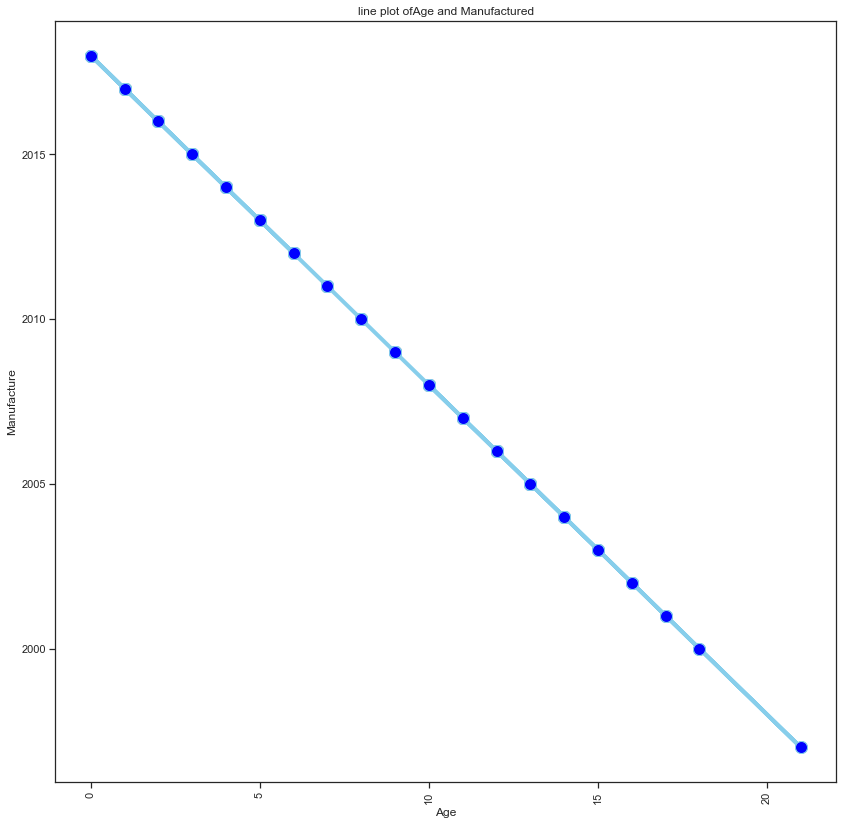

In [42]:
# scatter plot of Age and EngineSize and Manufactured

# multiple line plot
f, axes = plt.subplots(1, 1, figsize=(14, 14), sharex=True)
plt.plot( 'Age', 'Manufactured', data=vehicle_clean_df1, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.title('line plot ofAge and Manufactured')
plt.xlabel('Age')
plt.ylabel('Manufacture')
plt.xticks(rotation='vertical')
#plt.legend(loc='best')
plt.show()

In [43]:
# There is a high correlation between the Age and Manufactured Year which is inversely proportional
# as expected

In [44]:
# No pattern exists on the plot of Engine size with Damage category
# Transforming EngineSize and grouping could improve the relationship with other variables.

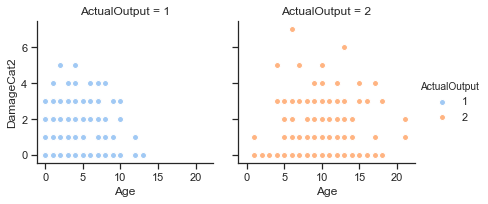

In [45]:
g = sns.FacetGrid(vehicle_clean_df1, col="ActualOutput",  hue="ActualOutput")
g = (g.map(plt.scatter, "Age", "DamageCat2", edgecolor="w")
     .add_legend())


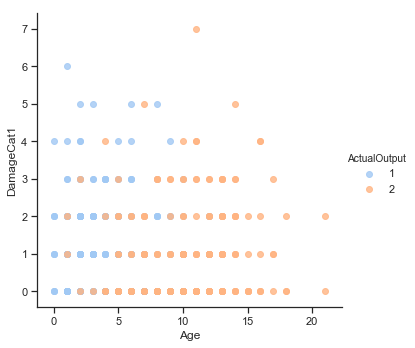

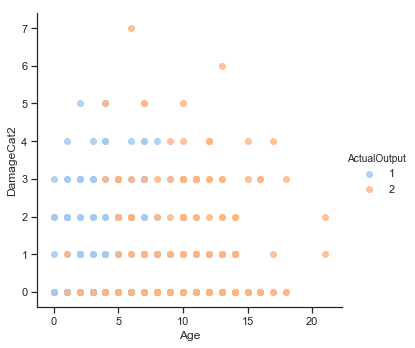

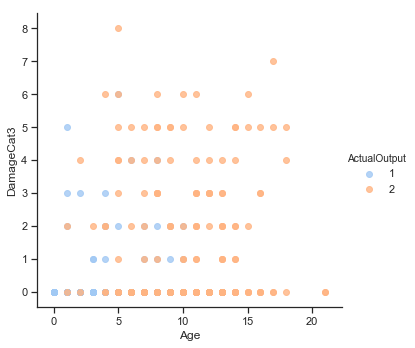

In [46]:
#plot data with seaborn
facet =sns.lmplot(data=vehicle_clean_df1, x='Age', y='DamageCat1', hue='ActualOutput', 
                   fit_reg=False, legend=True, legend_out=True)
facet =sns.lmplot(data=vehicle_clean_df1, x='Age', y='DamageCat2', hue='ActualOutput', 
                   fit_reg=False, legend=True, legend_out=True)
facet =sns.lmplot(data=vehicle_clean_df1, x='Age', y='DamageCat3', hue='ActualOutput', 
                   fit_reg=False, legend=True, legend_out=True)

In [47]:
# The scatter plot shows cluster of samples with ActualOutput =1 in the lower value range of Age
# While ActualOutput =2 is in the higher value range of Age

In [48]:
#4.0 Feature Engineering
# This is a process of transforming, extracting, data to obtain better predictive features for modeling 

In [50]:
vehicle_feat_df = vehicle_clean_df1.copy()

vehicle_feat_df.nunique()  # unique values

Unnamed: 0       400
IDField          400
Manufactured      20
Age               20
EngineSize        96
DamageCat1         8
DamageCat2         8
DamageCat3         9
ActualOutput       2
vmake             34
vehicletype       13
EngineSizeLog     96
dtype: int64

In [51]:
vehicle_feat_df.shape

(400, 12)

In [52]:
# EngineSize has 96 unique values. The histogram indicates a skewed data.
# Testing log transformation, decile binning for transfprmation
# Log transformation was implemented in visualisation

# The log transformation was already tested in EDA visualisation
#vehicle_clean_df1.loc[:,"EngineSizeLog"] = (vehicle_clean_df.loc[:,"EngineSize"]).apply(np.log)

In [53]:
# decile binning of EngineSize  

decile_list = [0, .1, .2, .3, .4,.5,.6 ,.7,.8,.9, 1.]
deciles = vehicle_feat_df['EngineSize'].quantile(decile_list)  # QC the decile distribution

deciles

0.0     875.0
0.1    1120.2
0.2    1241.6
0.3    1329.0
0.4    1395.0
0.5    1560.0
0.6    1598.0
0.7    1896.0
0.8    1988.0
0.9    2013.4
1.0    3999.0
Name: EngineSize, dtype: float64

Text(0,0.5,'Frequency')

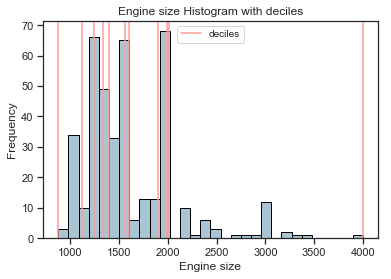

In [54]:
fig, ax = plt.subplots()
vehicle_feat_df['EngineSize'].hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
for decile in deciles:
    qvl = plt.axvline(decile, color='r')
ax.legend([qvl], ['deciles'], fontsize=10)
ax.set_title('Engine size Histogram with deciles', 
             fontsize=12)
ax.set_xlabel('Engine size', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)


In [55]:
# Considering loss of information in EngineSize data, the log transformed data was prefered
# in the modelling as it handled skewed data with better distribution.


In [56]:
#4.0 Transforming Vehicle Make (vmake variable)
# Label Encoder function

# This function will be used for encoding categorical values to numerical values.
# The label encoder from scikit-learn is used in craeting the function
from sklearn.preprocessing import LabelEncoder

def lbencode(df,col):
    ''' This function returns the label encoded values of the text column'''
    lb_encd = LabelEncoder()
    return lb_encd.fit_transform(df[col])

# call function

#print(lbencode(trial_df,'col'))



In [57]:
# label encode vmake and craete a column for the codes
vehicle_feat_df['vmake_lbcode'] = lbencode(vehicle_feat_df, 'vmake')

# label encode vehicletype and craete a column for the codes
vehicle_feat_df['vehicletype_lbcode'] = lbencode(vehicle_feat_df, 'vehicletype')


In [58]:
vehicle_feat_df.head(5)

,Unnamed: 0,IDField,Manufactured,Age,EngineSize,DamageCat1,DamageCat2,DamageCat3,ActualOutput,vmake,vehicletype,EngineSizeLog,vmake_lbcode,vehicletype_lbcode
0,0,98721,2008,10,998.0,1,1,1,2,toyota,hatchback,6.905753,30,5
1,1,98016,2005,13,1490.0,0,1,4,2,suzuki,hatchback,7.306531,29,5
2,2,98011,2008,10,1598.0,1,0,1,2,renault,mpv,7.376508,24,8
3,3,97974,2006,12,1910.0,1,0,3,2,vauxhall,mpv,7.554859,31,8
4,4,97960,2004,14,1240.0,2,1,0,2,nissan,hatchback,7.122867,21,5


In [97]:
vehicle_feat_df.head(5)

,Unnamed: 0,IDField,Manufactured,Age,EngineSize,DamageCat1,DamageCat2,DamageCat3,ActualOutput,vmake,vehicletype,EngineSizeLog,vmake_lbcode,vehicletype_lbcode
0,0,98721,2008,10,998.0,1,1,1,2,toyota,hatchback,6.905753,30,5
1,1,98016,2005,13,1490.0,0,1,4,2,suzuki,hatchback,7.306531,29,5
2,2,98011,2008,10,1598.0,1,0,1,2,renault,mpv,7.376508,24,8
3,3,97974,2006,12,1910.0,1,0,3,2,vauxhall,mpv,7.554859,31,8
4,4,97960,2004,14,1240.0,2,1,0,2,nissan,hatchback,7.122867,21,5


In [98]:
# Drop the original variable 'EngineSize','vmake','vehicletype' after transformation and encoding

vehicle_feat_df1 = vehicle_feat_df.drop(['IDField','EngineSize','ActualOutput','vmake','vehicletype'], axis =1)

In [99]:
vehicle_feat_df1.head()

,Unnamed: 0,Manufactured,Age,DamageCat1,DamageCat2,DamageCat3,EngineSizeLog,vmake_lbcode,vehicletype_lbcode
0,0,2008,10,1,1,1,6.905753,30,5
1,1,2005,13,0,1,4,7.306531,29,5
2,2,2008,10,1,0,1,7.376508,24,8
3,3,2006,12,1,0,3,7.554859,31,8
4,4,2004,14,2,1,0,7.122867,21,5


In [100]:
vehicle_feat_df2 = vehicle_feat_df1.copy()

In [101]:
vehicle_feat_df2['ActualOutput'] = vehicle_feat_df['ActualOutput']

In [102]:
vehicle_feat_df2.head(3)

,Unnamed: 0,Manufactured,Age,DamageCat1,DamageCat2,DamageCat3,EngineSizeLog,vmake_lbcode,vehicletype_lbcode,ActualOutput
0,0,2008,10,1,1,1,6.905753,30,5,2
1,1,2005,13,0,1,4,7.306531,29,5,2
2,2,2008,10,1,0,1,7.376508,24,8,2


In [103]:
vehicle_feat_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
Unnamed: 0            400 non-null int64
Manufactured          400 non-null int64
Age                   400 non-null int64
DamageCat1            400 non-null int64
DamageCat2            400 non-null int64
DamageCat3            400 non-null int64
EngineSizeLog         400 non-null float64
vmake_lbcode          400 non-null int64
vehicletype_lbcode    400 non-null int64
ActualOutput          400 non-null int64
dtypes: float64(1), int64(9)
memory usage: 31.3 KB


In [104]:
# Save the feature enginered dataframe to disk1 as a csv file

vehicle_feat_df2.to_csv("/vehicle_feat_df2.csv")   # save out the data to disc


In [105]:
vehicle_feat_df2 = pd.read_csv("/vehicle_feat_df2.csv")

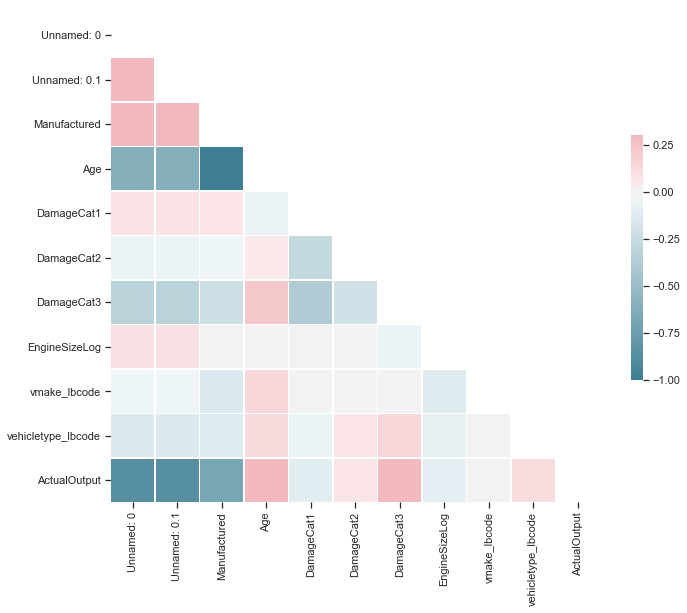

In [106]:
# plot of correlation matrix

# Compute the correlation matrix
corr = vehicle_feat_df2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [107]:
# The variables manufactured and Age indicate high negative correlation of -1
# Dropping Manufacturing and replot the correlation matrix

In [108]:
vehicle_feat_df3 = vehicle_feat_df2.drop(['Manufactured'], axis =1)

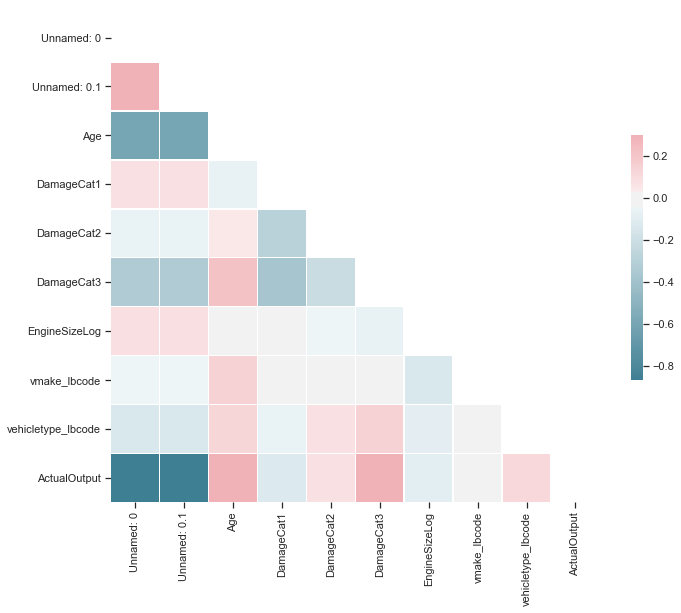

In [109]:
# plot of correlation matrix

# Compute the correlation matrix
corr1 = vehicle_feat_df3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [110]:
# Select Features and target data, then split the model training and test data

target_df = vehicle_feat_df2['ActualOutput']  # target output

features_df = vehicle_feat_df2[['Manufactured','Age','DamageCat1','DamageCat2','DamageCat3','EngineSizeLog','vmake_lbcode',
                             'vehicletype_lbcode']]  # features output

In [114]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
Manufactured          400 non-null int64
Age                   400 non-null int64
DamageCat1            400 non-null int64
DamageCat2            400 non-null int64
DamageCat3            400 non-null int64
EngineSizeLog         400 non-null float64
vmake_lbcode          400 non-null int64
vehicletype_lbcode    400 non-null int64
dtypes: float64(1), int64(7)
memory usage: 25.1 KB


In [112]:
target_df.shape

(400,)

In [113]:
# feature scalling
# Feature scaling improves the convergence of steepest descent algorithms, which do not possess 
#the property of scale invariance
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

std_scale = preprocessing.StandardScaler().fit(features_df)
df_std = std_scale.transform(features_df)
features_scaled_df = df_std

In [76]:
#5.1  Train test splitting
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Make a train/test split using 20% test size
X_train, X_test, y_train, y_test = train_test_split(features_scaled_df, target_df,
                                                    test_size=0.20,
                                                    random_state=21)

In [77]:
# Feature Seletion  (Recursive Feature Elimination)
# Recursive Feature Elimination (RFE) repeatedly constructs a model and choose eitherthe best or worst 
# performing features. The goal of RFE is to select features by recursively considering smaller 
# and smaller sets of features.

y=target_df
X=features_df
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1]


In [78]:
# Allfeatures are selected as good for modelling. 

In [79]:
# 5.0 Model fitting
#In the binary classification task, the following models are fitted and comapred using different 
# evaluation metrics. Logistic regression, NaiveBias, SVm, RandomForest, XGboost
# Gradient Descent parameter optimisation

In [80]:
# Logistic regaression

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train, y_train)



LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [81]:
#Score is Mean Accuracy
logistic_score = lr.score(X_test,y_test)
print( 'logisticregression score: ', logistic_score)

logisticregression score:  0.85


In [82]:
# Grid search optimisation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

# Create logistic regression
lrg = LogisticRegression(random_state=0)             # initialize the model

# parameter grid
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [1.0,1.5,2.0,2.5]
# Create hyperparameter options
param_grid = dict(dual=dual,max_iter=max_iter,C=C)

# Grid search
random = RandomizedSearchCV(estimator=lrg, param_distributions=param_grid, cv = 10, scoring = 'accuracy')


In [83]:
random_result = random.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.865625 using {'max_iter': 100, 'dual': True, 'C': 2.5}


In [84]:
# Evaluate the classifier by using accuracy measure
# Apply the trained Classifier to the test data (which, remember, it has never seen before to measure accuracy)
print("classifier accuracy:", random.score(X_test, y_test))  # score model

classifier accuracy: 0.85


In [85]:
from sklearn.metrics import confusion_matrix

# predict with best model
# Evaluate the classifier by using confusion matrix compare y predicted to actual y values

# Apply the trained Classifier to the X-test data and make predictions
y_pred = random.predict(X_test)  # use model to predict on test data for generalisation
y_true = y_test
# create confusion matrix

confusion_matrix(y_true, y_pred)

array([[32,  5],
       [ 7, 36]], dtype=int64)

In [86]:
pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1,2,All
True,,,
1,32,5,37
2,7,36,43
All,39,41,80


In [87]:
# precision, recall, F1-score
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_true, y_pred)

(array([0.82051282, 0.87804878]),
 array([0.86486486, 0.8372093 ]),
 array([0.84210526, 0.85714286]),
 array([37, 43], dtype=int64))

In [88]:
# RandomForest classifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import roc_auc_score
# Create a random forest Classifier. By convention, rf, put hyperparameters, default
rf = RandomForestClassifier(random_state=0)

# Train the Classifier to take the X-training features and learn how they 
# relate to the y-training target independent variable

rf.fit(X_train, y_train)  # fit model


C:\Users\yasser\Anaconda2\envs\pyt36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [89]:
# Evaluate Randomforest
print("classifier accuracy:", rf.score(X_test, y_test))  # score model

classifier accuracy: 0.8


In [90]:
# feature Importance
# Rank of the importance of feature
rf.feature_importances_

array([0.33364148, 0.19288894, 0.03945535, 0.04863389, 0.10300848,
       0.11154813, 0.10707497, 0.06374874])

In [91]:
# feature importance

feature_importances = pd.DataFrame(rf.feature_importances_,index = features_df.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

feature_importances.head()

,importance
Manufactured,0.333641
Age,0.192889
EngineSizeLog,0.111548
vmake_lbcode,0.107075
DamageCat3,0.103008


In [92]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=7)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7875


In [93]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8375


In [94]:
# Comparison of prediction accuracy by the models shows that logistic regression gave the best performance
# based on the data.The more data intensive estimators gave lower performance accuracy

# logistic regression 86%, support vector machine 83.75%, RandomForest 80% and K Nearest neighbour 78.75%
# The results from these base models shows that with more data, feature engineering and hyperparameter tunning
# on SVM,RandomForest and KNN, the accuracy can be improved.

In [122]:

bag_df = vehicle_feat_df2.copy()

bag_df = bag_df[['Manufactured','Age','DamageCat1','DamageCat2','DamageCat3','EngineSizeLog','vmake_lbcode','vehicletype_lbcode','ActualOutput']]
bag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
Manufactured          400 non-null int64
Age                   400 non-null int64
DamageCat1            400 non-null int64
DamageCat2            400 non-null int64
DamageCat3            400 non-null int64
EngineSizeLog         400 non-null float64
vmake_lbcode          400 non-null int64
vehicletype_lbcode    400 non-null int64
ActualOutput          400 non-null int64
dtypes: float64(1), int64(8)
memory usage: 28.2 KB


In [123]:
# combining different models
#Ensembling experiments.

from sklearn.preprocessing import MinMaxScaler
# features and Target dataset in vehicle_feat_df2



scaler = MinMaxScaler(feature_range=(0, 1))
normalized_df = scaler.fit_transform(bag_df)

X = normalized_df[:,0:7]
Y = normalized_df[:,8]


In [124]:
# Bagging based Ensembling. Using a Bagged Decision Tree.
# Bagged Decision Trees for Classification - necessary dependencies

from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier



kfold = model_selection.KFold(n_splits=10, random_state=7)
cart = DecisionTreeClassifier()
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=7)
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())



0.7975


In [125]:
# AdaBoost Classification

from sklearn.ensemble import AdaBoostClassifier
seed = 7
num_trees = 70
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())


0.8125
